# Model Training without fine-tuning

In [ ]:
# import packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Add, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
# read the experimental dataset
feature_path='.../test_spectra_sheet_raw.csv'
tbl = pd.read_csv(feature_path)
tbl = tbl.set_index('ID')
print(tbl.shape)

(6604, 3815)


In [ ]:
tbl.head(5)

,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
ID,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,0,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,3,0,1,3,1,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,2,2,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,1,1,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


(3815, 1)

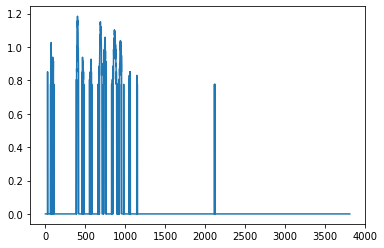

In [ ]:
def read_features(ID, desired_size = (3815,1), alpha = 0.5):
    try:    
        if alpha < 0.3:
            row = tbl.loc[ID,:]
            row[row < 5] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)            
        else:  
            row = tbl.loc[ID,:]
            row[row < 5] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)
    except:
        row = np.zeros(desired_size)        
    return row

a = read_features(30, (3815,1), 0.8)
plt.plot(a)
a.shape

In [ ]:
gt_path='.../test_label_13.csv'
gt = pd.read_csv(gt_path)
gt = gt.set_index('ID')
gt.shape

(6604, 13)

In [ ]:
def read_gt(ID, desired_size = (13,1)):
    try:
        row = gt.loc[ID,:]
#         row = np.expand_dim(row, axis = -1)
    except:
        row = np.zeros(desired_size)  
    
    return row
a = read_gt(4242, (13,1))
a.shape

(13,)

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=64, dim=tbl.shape[1], n_channels=1,
                     augment =False, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels))
        y = np.empty((self.batch_size, 13), dtype=np.float32)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.augment:
                alpha = np.random.uniform(0,1)
            else:
                alpha = 0.5
            XXX = read_features(ID, alpha=alpha)
            X[i,] = XXX

            y[i,] = read_gt(ID)

        return X, y

In [ ]:
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation = 'relu',input_shape=(tbl.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation="sigmoid", name='dense_output'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 3811, 64)          384       
_________________________________________________________________
batch_normalization_54 (Batc (None, 3811, 64)          256       
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1905, 64)          0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 1903, 64)          12352     
_________________________________________________________________
batch_normalization_55 (Batc (None, 1903, 64)          256       
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 951, 64)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 949, 64)          

In [ ]:
model.load_weights('.../model/model_deeper_bg_13.hdf5') #_noise.hdf5

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tbl, gt, test_size=0.80, random_state=42)

print(X_train.shape, X_test.shape)

(1320, 3815) (5284, 3815)


In [ ]:
train_generator = DataGenerator(X_train.index, 1, X_train.shape[1], 1, shuffle=False)
r_train = model.predict_generator(train_generator)

In [ ]:
test_generator = DataGenerator(X_test.index, 1, X_test.shape[1], 1, shuffle=False)
r_test = model.predict_generator(test_generator)

In [ ]:
classes = gt.columns
classes.shape

(13,)

In [ ]:
Acc = []
pre = []
f1 = []
recall = []

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
for i in range(13):
    ex = classes[i]
    result_test = (r_test > f1_max[i])*1.0  
    print('{}_acc: {}'.format(ex, accuracy_score(result_test[:,i], y_test[classes[i]])))
    Acc.append( accuracy_score(result_test[:,i], y_test[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result_test[:,i], y_test[classes[i]])))
    pre.append( precision_score(result_test[:,i], y_test[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result_test[:,i], y_test[classes[i]])))
    f1.append( f1_score(result_test[:,i], y_test[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result_test[:,i], y_test[classes[i]])))
    recall.append( recall_score(result_test[:,i], y_test[classes[i]]))
    print(classification_report(y_test[classes[i]], result_test[:,i]))
    print('************************************')

In [ ]:
# evaluate the results
coms = gt.drop_duplicates()

In [ ]:
# all training and testing together
t_generator = DataGenerator(tbl.index, 1, tbl.shape[1], 1, shuffle=False)
r_train = model.predict_generator(t_generator)

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
for i in range(13):
    ex = classes[i]
    result_test = (r_train > f1_max[i])*1.0  
    print('{}_acc: {}'.format(ex, accuracy_score(result_test[:,i], gt[classes[i]])))
    Acc.append( accuracy_score(result_test[:,i], gt[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result_test[:,i], gt[classes[i]])))
    pre.append( precision_score(result_test[:,i], gt[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result_test[:,i], gt[classes[i]])))
    f1.append( f1_score(result_test[:,i], gt[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result_test[:,i], gt[classes[i]])))
    recall.append( recall_score(result_test[:,i], gt[classes[i]]))
    print(classification_report(gt[classes[i]], result_test[:,i]))
    print('************************************')

In [ ]:
result = (r>0.05)*1.0                     
result.shape

(6604, 11)

In [ ]:
gt.shape

(6604, 11)

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(gt['Chromate'], result[:,-2]))

In [ ]:
classes = gt.columns
classes.shape

(11,)

In [ ]:
Acc = []
pre = []
f1 = []
recall = []

In [4]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

for i in range(11):
    ex = classes[i]
    print('{}_acc: {}'.format(ex, accuracy_score(result[:,i], gt[classes[i]])))
    Acc.append( accuracy_score(result[:,i], gt[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result[:,i], gt[classes[i]])))
    pre.append( precision_score(result[:,i], gt[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result[:,i], gt[classes[i]])))
    f1.append( f1_score(result[:,i], gt[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result[:,i], gt[classes[i]])))
    recall.append( recall_score(result[:,i], gt[classes[i]]))
    print(classification_report(gt[classes[i]], result[:,i]))
    print('************************************')

# Visualizations

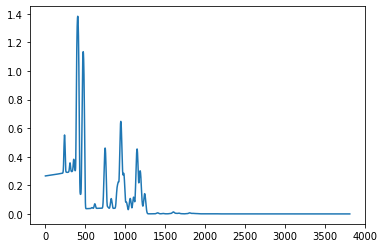

In [ ]:
IIDD = 999

a = read_features(IIDD, (4096,1), 0.5)  # 8000
plt.plot(a)
a.shape
a = np.expand_dims(a, axis = 0)

In [ ]:
res_a = model.predict(a)

In [ ]:
res_a

array([[3.4183264e-05, 9.9981350e-01, 2.1219254e-05, 1.2906492e-03,
        2.3272336e-03, 2.0205975e-05, 1.4901161e-07, 6.7800283e-05,
        9.3315521e-06, 9.3107885e-01, 5.4375295e-02]], dtype=float32)

In [ ]:
gt_a = read_gt(IIDD, (13,1))
gt_a

Cadmium yellow      0
Cobalt blue         1
Emerald green       0
Iron oxide          0
Prussian blue       0
SnO1                0
Ultramarine blue    0
Vermilion           0
ZnO                 0
Chromate            1
Lead                0
Name: 999, dtype: int64

In [ ]:
target_class = np.argmax(res_a)
# target_class = 6
print(target_class)

1


In [ ]:
last_conv = model.get_layer('conv1d_5') 
grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(a)
    #get activations maps + predictions from last conv layer
    loss = predictions[:, target_class] 
    # the variable loss gets the probability of belonging to the defined class (the predicted class on the model output)

W1010 14:54:49.555972 140280867051328 base_layer.py:1814] Layer conv1d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
output = conv_outputs[0] #activations maps from last conv layer
grads = tape.gradient(loss, conv_outputs) #function to obtain gradients from last conv layer

print("grads shape:", grads.shape)
print("Model output (loss for the target class):", loss.shape)
print("Output froom lat conv layer", conv_outputs.shape)

grads shape: (1, 115, 128)
Model output (loss for the target class): (1,)
Output froom lat conv layer (1, 115, 128)


(1, 115, 128)


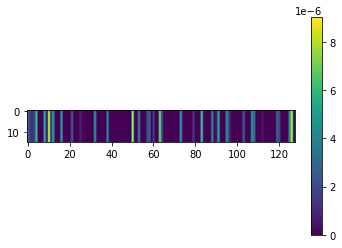

In [ ]:
# Apply guided backpropagation
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

print(guided_grads.shape)
guide_grads_example = guided_grads[:,0,:]
# print(guide_grads_example.shape)
guide_grads_example = np.squeeze(guide_grads_example, 0)
# plt.plot(np.squeeze(guide_grads_example, 0)) 
plt.show() 

guided_grads_image = [guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example]
plt.imshow(guided_grads_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

In [ ]:
weights = tf.reduce_mean(guided_grads, axis=(0,1))
#print("weights shape", weights.shape) 
print("min", np.min(weights))
print("max", np.max(weights))

#plt.plot(weights) 
#plt.show() 

#Weight of each filter in the conv layer 
weights

min 5.007614e-08
max 3.1187792e-06


<tf.Tensor: id=7216787, shape=(128,), dtype=float32, numpy=
array([4.9864786e-07, 3.5013048e-07, 3.2603003e-07, 3.1187792e-06,
       3.3758730e-07, 1.2311391e-07, 1.2057940e-06, 2.8222752e-07,
       4.4143786e-07, 1.2784071e-06, 2.5266577e-06, 4.1653215e-07,
       2.0722698e-06, 2.7749634e-06, 2.2880085e-06, 5.7447681e-07,
       1.5671886e-06, 2.0134191e-06, 1.2079389e-06, 1.5740779e-06,
       1.3533223e-06, 2.2936972e-06, 1.6290826e-06, 4.4328462e-07,
       1.6236883e-06, 4.1790068e-07, 4.2872412e-07, 4.0273059e-07,
       1.2660421e-07, 6.5051017e-07, 9.8813109e-07, 1.7455010e-06,
       1.8569689e-06, 1.6642780e-06, 3.2992958e-07, 2.5294635e-06,
       8.9993136e-07, 1.8977787e-06, 3.6397950e-07, 3.1205232e-07,
       4.9701117e-07, 1.6564221e-06, 2.6670634e-06, 4.5250630e-07,
       2.2240590e-06, 1.2891524e-06, 3.6597345e-07, 1.8575265e-06,
       3.1087885e-07, 1.3830788e-06, 7.7100435e-07, 7.0738139e-07,
       2.4724427e-06, 5.2528446e-07, 4.2561857e-07, 1.9521940e-06,
  

min 1.000030380779208
max 1.000111846042273


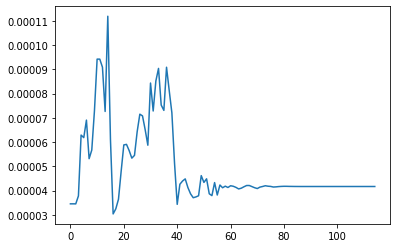

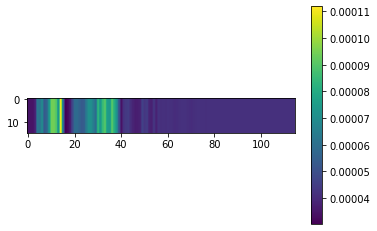

In [ ]:
cam = np.zeros(output.shape[0], dtype = np.float128)
cam
# print(cam.shape)
for i, w in enumerate(weights):
#     print(w)
    cam += w * output[:, i]
#     print(cam)
    
print("min", np.min(cam) + 1.0)
print("max", np.max(cam) + 1.0)

plt.plot(cam) 
plt.show() 

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

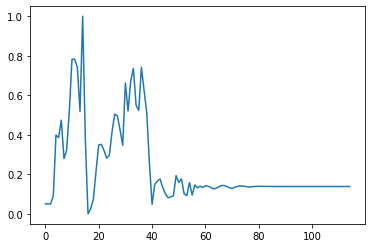

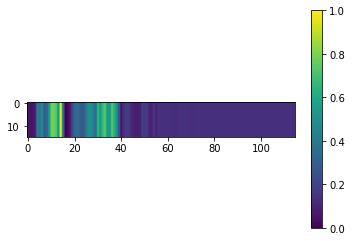

In [ ]:
cam = np.maximum(cam, 0)
cam = (cam - cam.min()) / (cam.max() - cam.min())

plt.plot(cam) 
plt.show()

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) 
plt.colorbar()
plt.show()

# b =  signal.resample(a[0,:,0], 128)
# b.shape

# plt.plot(b)
# plt.plot(cam, c = 'red')

In [ ]:
a.shape

(1, 3815, 1)

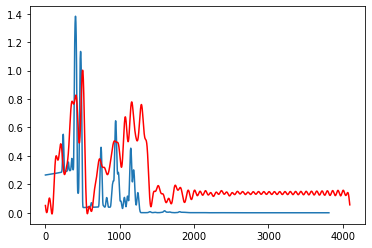

In [ ]:
from scipy import signal
f = signal.resample(cam, 4096)
plt.plot(a[0,:,0])
plt.plot(f, c = 'red')

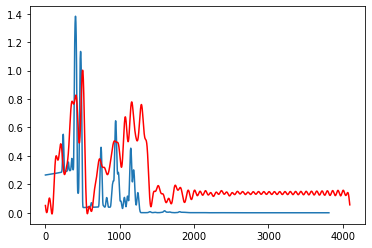

In [ ]:
from scipy import signal
f = signal.resample(cam, 4096)
plt.plot(a[0,:,0])
plt.plot(f, c = 'red')

In [ ]:
# # try
# pooled_grads = tf.reduce_mean(grads, axis = (0, 1))
# pooled_grads.shape

# conv_outputs_reduce = conv_outputs[0]
# heatmap = conv_outputs_reduce @ pooled_grads[..., tf.newaxis]
# heatmap = tf.squeeze(heatmap)
# heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# print(heatmap.shape)
# # heatmap = tf.squeeze(heatmap)

# Activation_map_image = [heatmap, heatmap, heatmap, heatmap, heatmap, heatmap, heatmap,
#                        heatmap, heatmap,heatmap, heatmap, heatmap, heatmap, heatmap, heatmap]
# plt.imshow(Activation_map_image) # vmin=-1, vmax=1) #cmap='gray
# plt.colorbar()

# from scipy import signal
# b =  signal.resample(a[0,:,0], 128)
# b.shape

# plt.plot(b)
# plt.plot(heatmap, c = 'red')

TensorShape([128])

# Mistakes

In [ ]:
predicted = pd.DataFrame(data=result[:,:], index=y_test.index, columns=y_test.columns)  # 1st row as the column names

In [ ]:
y_test['Emerald green'] == result[:,2]

ID
4679     True
2805     True
1683     True
862      True
14444    True
         ... 
15494    True
10083    True
8183     True
14155    True
6339     True
Name: Emerald green, Length: 3245, dtype: bool

In [ ]:
cobalt_blue = y_test['Emerald green'] == result[:,2]

In [ ]:
temp = predicted[cobalt_blue == False]
temp
# temp[temp['Cobalt blue'] == True]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5561,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y_test[cobalt_blue == False]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0,0,0,0,0,0,0,1,1,0,0
7283,0,0,1,0,0,0,0,1,0,0,0
5561,0,0,1,0,0,1,0,0,0,0,0
9886,0,0,1,0,0,0,0,0,0,1,0
5562,0,0,1,0,0,1,0,0,0,0,0
5556,0,0,1,0,0,1,0,0,0,0,0
9864,0,0,1,0,0,0,0,0,0,1,0
3804,0,0,1,0,0,0,0,0,0,0,1
9875,0,0,1,0,0,0,0,0,0,1,0


# Plot Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm = multilabel_confusion_matrix(y_test, result)

In [ ]:
gt.columns

Index(['Cadmium yellow', 'Cobalt blue', 'Emerald green', 'Iron oxide',
       'Prussian blue', 'SnO1', 'Ultramarine blue', 'Vermilion', 'ZnO',
       'Chromate', 'Lead'],
      dtype='object')

In [ ]:
cm.shape

(11, 2, 2)

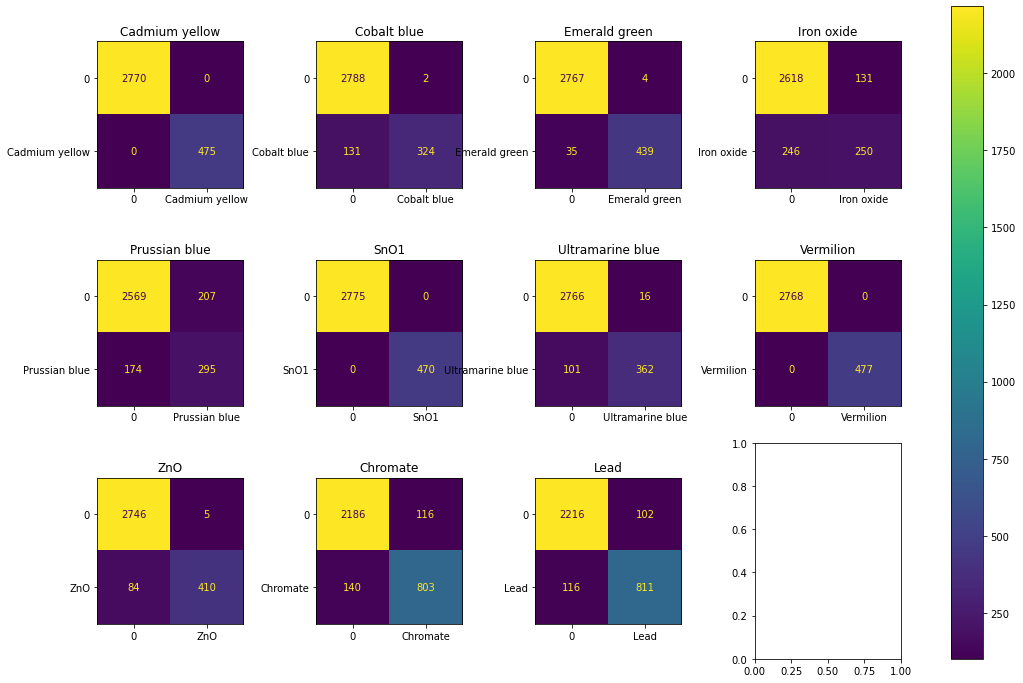

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()
for i in range(13):
    disp = ConfusionMatrixDisplay(cm[i,:,:],
                                  display_labels=[0, gt.columns[i]])
    disp.plot(ax=axes[i], values_format= '.4g')
    disp.ax_.set_title('{}'.format(gt.columns[i]))
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
#     disp.plot()

plt.subplots_adjust(wspace=0.5, hspace=0.01)
f.colorbar(disp.im_, ax = axes)
plt.show()